## General

This notebook walks through the current steps in the `kmerfeatures.score` module in an attempt to iterate upon and improve the process.

## Initialize code

In [1]:
# general imports
import pandas as pd
import numpy as np
import kmerfeatures as kmf

# data viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# clustering imports
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

# dimensionality reduction (for visualization)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Convert example output

I wrote a utility to convert the output file into two separate npy arrays containing IDs and vectors, respectively. The npy format will be useful for directly connecting the output to a scoring module in the pipeline.

In [2]:
seq_ids, vectors = kmf.utils.output_to_npy("example_features_1.txt", id_length=6)

seq_ids.shape, vectors.shape

((408,), (408, 1172))

## Clustering

Using the `AgglomerativeClustering` method implemented by Jason, I am generating 2 clusters from the vectorized data. (Note: the number of clusters can be specified as an argument in `AgglomerativeClustering`. Also, note that I am scoring distances between vectors themselves rather than dimensions, e.g. I am not taking `vectors.T` as is currently implemented in the kmerfeatures code.)

In [3]:
distance_matrix = 1 - pairwise_distances(vectors, metric='hamming')

clusters = AgglomerativeClustering().fit_predict(distance_matrix)
clusters.shape

(408,)

## Visualization

In order to assess how the generated clusters map to the vectorized data, I am using principal components analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE) to reduce the dimensionality of the data into two dimensions. Both are commonly used dimensionality reduction techniques.

#### Why PCA?

Principal component analysis (PCA) is a dimensionality reduction technique. Since the data are in 1172-element arrays, some form of dimensionality reduction makes sense, particularly to visualize how the clusters are formed.

In [4]:
# initialize and fit PCA
pca = PCA(n_components=20)
vectors_pca = pca.fit_transform(vectors)

# reformat data from arrays into dfs for seaborn
vec_df = pd.DataFrame(vectors)
vec_df['cluster'] = clusters
vec_df.columns = [str(col) for col in vec_df.columns]
vec_pca_df = pd.DataFrame(vectors_pca, columns=[f"PC{n + 1}" for n in range(vectors_pca.shape[1])])
vec_pca_df['cluster'] = clusters

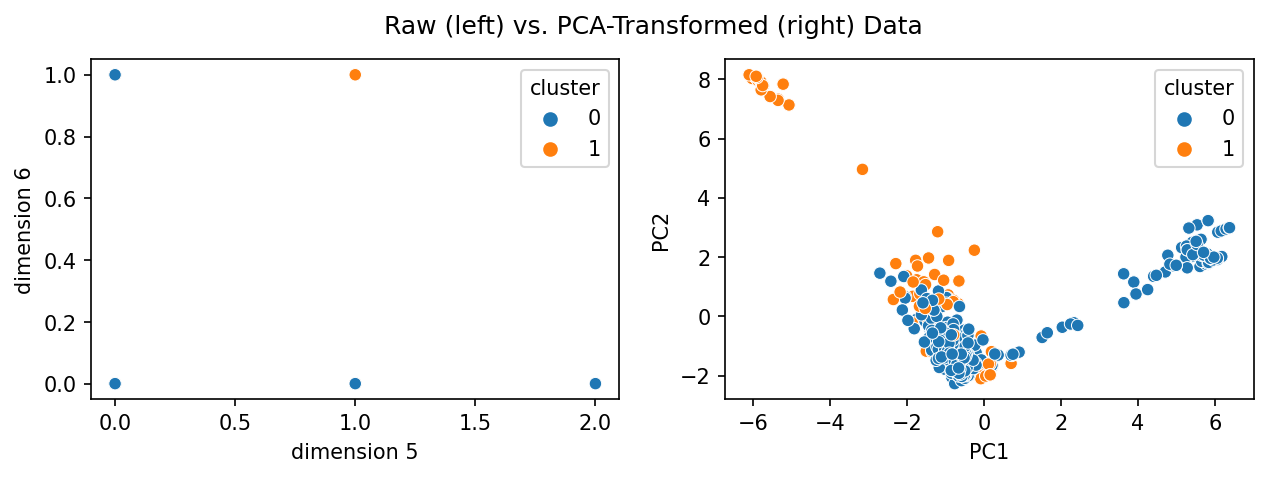

In [5]:
# specify dimensions of the non-transformed data
dim_i, dim_j = 5, 6

# specify PC dimensions
pc_i, pc_j = 1, 2

# plot all the features in the first 2 principal components, labeled w/ clusters
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10,3))
plt.suptitle("Raw (left) vs. PCA-Transformed (right) Data")

sns.scatterplot(data=vec_df, x=f'{dim_i}', y=f'{dim_j}', hue='cluster', ax=axs[0])
axs[0].set_xlabel(f"dimension {dim_i}")
axs[0].set_ylabel(f"dimension {dim_j}")


sns.scatterplot(data=vec_pca_df, x=f'PC{pc_i}', y=f'PC{pc_j}', hue='cluster', ax=axs[1])
axs[1].set_xlabel(f"PC{pc_i}")
axs[1].set_ylabel(f"PC{pc_j}")

plt.show()

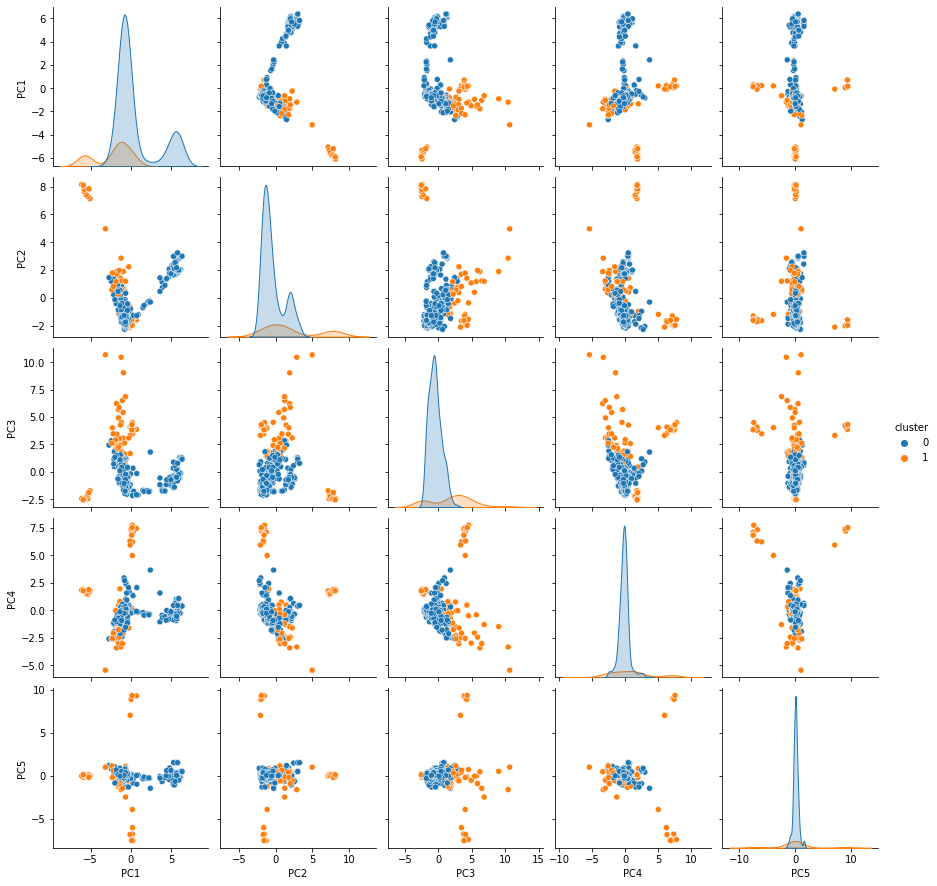

In [6]:
# visualize the first n principal components
n_components = 5
sns.pairplot(vec_pca_df[[f"PC{n + 1}" for n in range(n_components)] + ['cluster']], diag_kind='kde', hue='cluster')

plt.show()

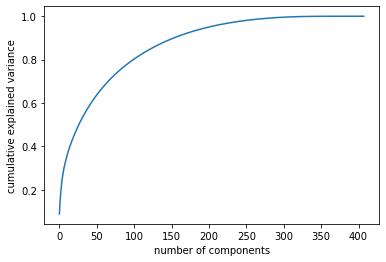

In [7]:
# explained variance
pca = PCA().fit(vectors)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#### t-SNE

From `sklearn.manifold.TSNE` documentation:

    t-distributed Stochastic Neighbor Embedding.

    t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

    It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. For more tips see Laurens van der Maaten’s FAQ.

In [8]:
# initialize tsne (note: params can be played with)
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(vectors)

# reformat data into seaborn-friendly df
tsne_2d = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
tsne_2d['cluster'] = clusters

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.008s...
[t-SNE] Computed neighbors for 408 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 2.800360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.043488
[t-SNE] KL divergence after 1000 iterations: 1.161023


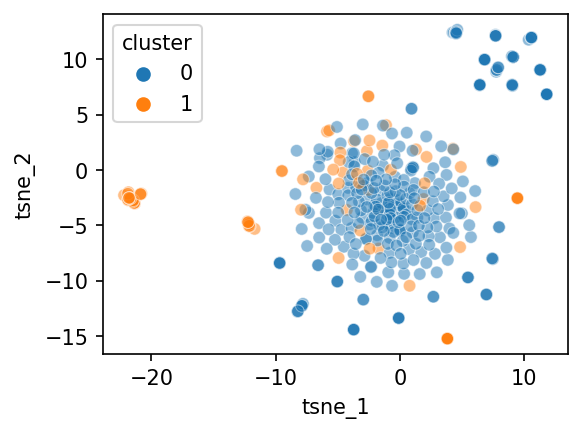

In [9]:
# plot t-sne clusters
fig, ax = plt.subplots(dpi=150, figsize=(4,3))

sns.scatterplot(x="tsne_1", y="tsne_2", hue="cluster", data=tsne_2d, alpha=0.5)

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.001s...
[t-SNE] Computed neighbors for 408 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 1.522889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.134811
[t-SNE] KL divergence after 1000 iterations: 0.782896


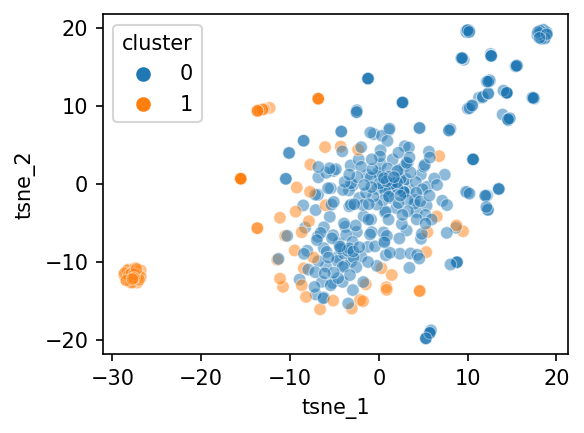

In [10]:
# t-sne with dimensionality reduction (via PCA)
pca50 = PCA(n_components=50)
vectors_pca50 = pca50.fit_transform(vectors)

# initialize t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(vectors_pca50)

# put into df for seaborn
tsne_2d = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
tsne_2d['cluster'] = clusters

# generate plot
fig, ax = plt.subplots(dpi=150, figsize=(4,3))
sns.scatterplot(x="tsne_1", y="tsne_2", hue="cluster", data=tsne_2d, alpha=0.5)
plt.show()